## import

In [82]:
import time
import pandas as pd
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from healpy.fitsfunc import read_map

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
#colors = sns.color_palette("colorblind").as_hex()
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)


## extract CMB maps and masks

In [87]:
# Define some fixed params
NSIDE = 2048                                                                      # given in the name of the maps
FREQ = 143                                                                        # fixed for this project
gal_cover = 80                                                                    # can be varied for different covers of galactic plane

GALCOVER_DICT = {
    'GAL020': 0,
    'GAL040': 1,
    'GAL060': 2,
    'GAL070': 3,
    'GAL080': 4,
    'GAL090': 5,
    'GAL097': 6,
    'GAL099': 7
}

FREQ_PS_DICT = {
    'F100': 0,
    'F143': 1,
    'F217': 2,
    'F353': 3,
    'F545': 4,
    'F857': 5,
} 

def extract_data(filepath, field, hdu=1):
    '''
    Extracts input HDU from map Planck FITS file (we only need the first one)
    Document function once fully tested
    '''
    
    hdul = fits.open(filepath)
    data = hdul[hdu].data                    # hdul is a list of HDU objects

    hdul.info()                              # prints metadata about FITS file (HDUs)
    
    print(hdul[hdu].header)
    
    print('='*90)
    hdul.close()                    
    
    return data

# Define each filepath
filenames = ['HFI_SkyMap_143_2048_R3.01_halfmission-1.fits',        # map for half mission 1 143 GHZ
             'HFI_SkyMap_143_2048_R3.01_halfmission-2.fits',        # map for half mission 2 143 GHZ
             'HFI_Mask_GalPlane-apo5_2048_R2.00.fits',              # galactic plane mask for input apodization
             'HFI_Mask_PointSrc_2048_R2.00.fits',                   # mask point source
             'Bl_T_R3.01_fullsky_143hm1x143hm1.fits',               # beam transfer function for hm1
             'Bl_T_R3.01_fullsky_143hm1x143hm2.fits',               # beam transfer function for hm2
            ]

start1 = time.time()
# extract data
datalist = []
for filename in filenames:
    #data_i = read_map('data/'+filename, field=0, hdu=1, h=False)
    data_i = extract_data('data/'+filename)
    datalist.append(data_i)
        
end1 = time.time()
print(f'It took {end1-start1:.2f}s. to extract the Planck data files.')

sky_hm1, sky_hm2, mask_gp, mask_ps = datalist[:4]
beamf_hm1, beamf_hm2 = datalist[4:]

Filename: data/HFI_SkyMap_143_2048_R3.01_halfmission-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  FREQ-MAP      1 BinTableHDU     75   50331648R x 10C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E']   
XTENSION= 'BINTABLE'           /Written by IDL:  Mon Sep  3 20:23:32 2018       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   40 /Number of bytes per row                         NAXIS2  =             50331648 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                   10 /Number of columns                               COMMENT                                                                  

XTENSION= 'BINTABLE'           /Written by IDL:  Mon Sep  3 20:51:24 2018       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   40 /Number of bytes per row                         NAXIS2  =             50331648 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                   10 /Number of columns                               COMMENT                                                                         COMMENT  *** End of mandatory fields ***                                        COMMENT                                                                         EXTVER  =                    1 /Extension version                               DATE    = '2018-09-03'         /Creation

XTENSION= 'BINTABLE'           /Written by IDL:  Tue Dec  9 17:16:06 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   32 /Number of bytes per row                         NAXIS2  =             50331648 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    8 /Number of columns                               COMMENT                                                                         COMMENT  *** End of mandatory fields ***                                        COMMENT                                                                         EXTVER  =                    1 /Extension version                               DATE    = '2014-12-09'         /Creation

Filename: data/Bl_T_R3.01_fullsky_143hm1x143hm1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  WINDOW FUNCTION    1 TableHDU        26   4001R x 1C   ['E15.7']   
XTENSION= 'TABLE   '           / ASCII table extension                          BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   15 / length of dimension 1                          NAXIS2  =                 4001 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    1 / number of table fields                         TTYPE1  = 'TEMPERATURE'                                                         TFORM1  = 'E15.7   '                     

0.0 180.0 -180.0 180.0


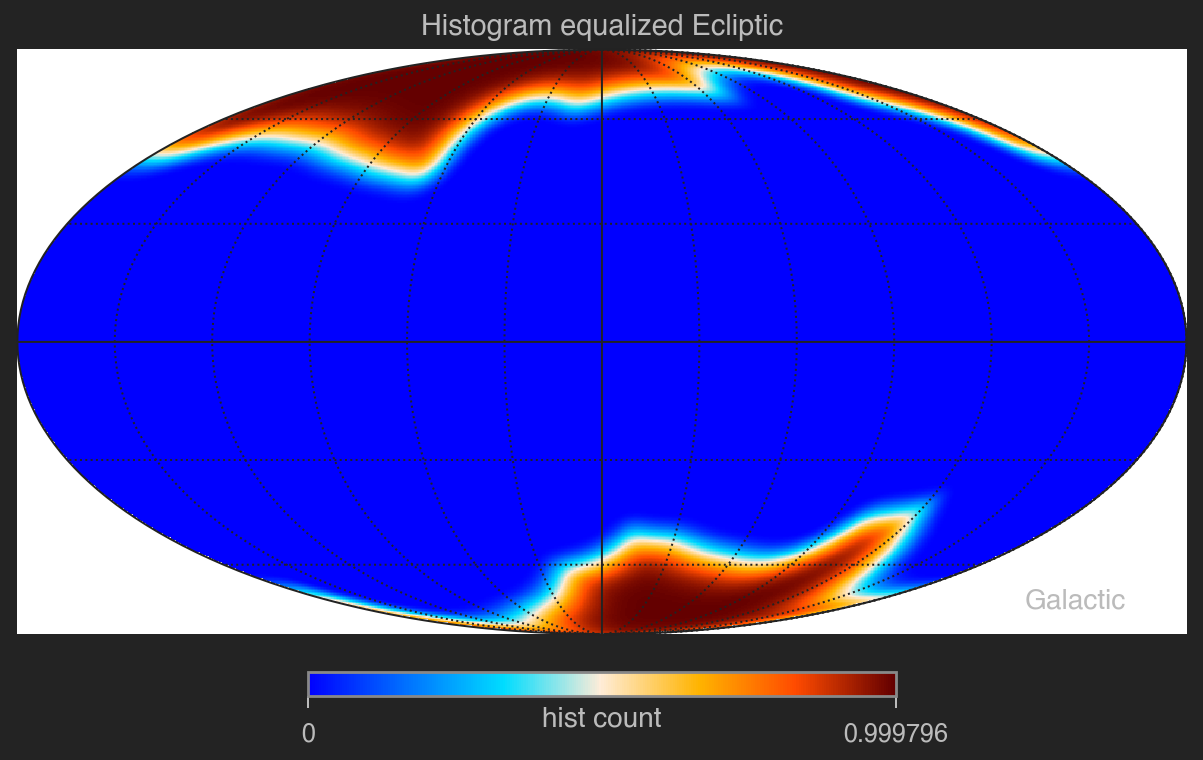

In [73]:
gp = read_map('data/'+filenames[2], hdu=1, h=False)
ps = 

hp.mollview(gp, coord=["G"],# norm="hist",
            title="Histogram equalized Ecliptic", unit="hist count", cmap=cmap)
hp.graticule()

In [90]:
sky_hm1['I_STOKES']

array([0.00272609, 0.00299759, 0.00274658, ..., 0.00408725, 0.00417517,
       0.00416275], dtype=float32)

In [91]:
print(array_list[0])

[-1.1961287e-04 -7.2607654e-05 -9.1664100e-05 ...  8.9846493e-05
  1.3174607e-04  1.2735845e-04]


In [97]:
hdul = fits.open('data/HFI_SkyMap_143_2048_R3.01_halfmission-1.fits')

print(hdul[1].data)

[(0.00272609, 3.3351902e-05, -1.3077862e-05,  876, 7.0497441e-10, 1.4236673e-10, -1.1294898e-10, 2.9556113e-09, -1.1944391e-11, 2.9654796e-09)
 (0.00299759, 9.2409027e-05,  5.7216388e-05,  907, 6.7086103e-10, 1.4272611e-10, -9.0823377e-11, 2.9330920e-09,  4.9399162e-11, 2.9220921e-09)
 (0.00274658, 2.1077467e-04, -4.2307802e-06,  812, 7.4237516e-10, 5.2963203e-11, -1.6235496e-10, 3.2959286e-09,  5.8355688e-11, 3.7227583e-09)
 ...
 (0.00408725, 7.9095676e-05, -2.3909812e-05,  901, 6.6759215e-10, 1.9858293e-10,  7.1013807e-12, 3.0962461e-09,  9.3065958e-11, 3.0557985e-09)
 (0.00417517, 1.4393758e-04, -1.9725262e-04,  973, 6.4122369e-10, 1.5754803e-10, -6.5604380e-12, 2.5311586e-09,  4.4700337e-11, 2.6938893e-09)
 (0.00416275, 4.5672972e-05, -6.1433260e-05, 1019, 6.0392114e-10, 1.5030290e-10,  1.8863553e-11, 2.4639613e-09,  5.2679548e-11, 2.6426927e-09)]


In [101]:
print(hdul[1].data.dtype)

(numpy.record, [('I_STOKES', '>f4'), ('Q_STOKES', '>f4'), ('U_STOKES', '>f4'), ('HITS', '>i4'), ('II_COV', '>f4'), ('IQ_COV', '>f4'), ('IU_COV', '>f4'), ('QQ_COV', '>f4'), ('QU_COV', '>f4'), ('UU_COV', '>f4')])


In [106]:
print(mask_gp)

[(0., 0., 0., 0., 0., 0., 0., 0.) (0., 0., 0., 0., 0., 0., 0., 0.)
 (0., 0., 0., 0., 0., 0., 0., 0.) ... (0., 0., 0., 0., 0., 0., 0., 0.)
 (0., 0., 0., 0., 0., 0., 0., 0.) (0., 0., 0., 0., 0., 0., 0., 0.)]


In [41]:
npy_filenames = ['HFI_SkyMap_143_2048_R3.01_halfmission-1.npy',        # map for half mission 1 143 GHZ
             'HFI_SkyMap_143_2048_R3.01_halfmission-2.npy',        # map for half mission 2 143 GHZ
             'HFI_Mask_GalPlane-apo5_2048_R2.00_GAL060_.npy',              # galactic plane mask for input apodization
             'HFI_Mask_PointSrc_2048_R2.00.npy',                   # mask point source
             'Bl_T_R3.01_fullsky_143hm1x143hm1.npy',               # beam transfer function for hm1
             'Bl_T_R3.01_fullsky_143hm1x143hm2.npy',               # beam transfer function for hm2
            ]

array_list = []
for npy_filename in npy_filenames:
    a = np.load('data/'+npy_filename)
    a[a ==  -1.6375e+30] = 0
    
    array_list.append(a)

0.0 180.0 -180.0 180.0


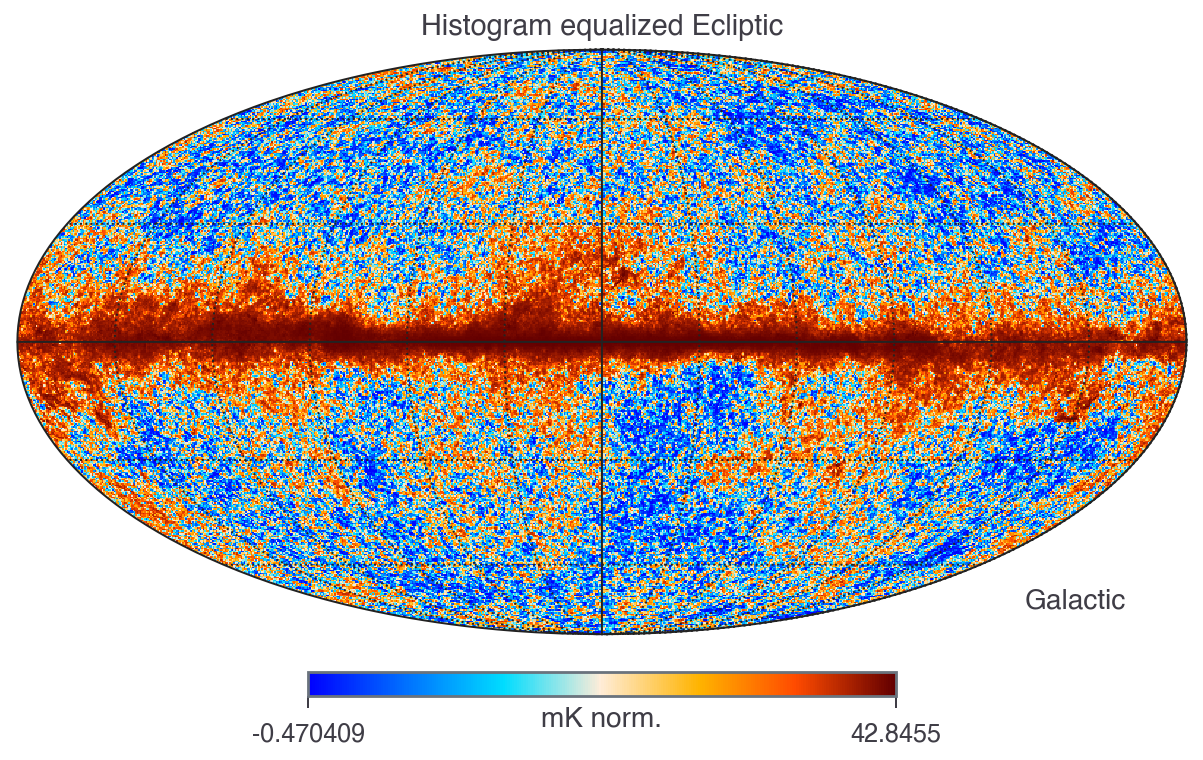

In [83]:
############### CMB colormap
from matplotlib.colors import ListedColormap
import numpy as np
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
colombi1_cmap.set_under("white") # color of background, necessary if you want to use
# this colormap directly with hp.mollview(m, cmap=colombi1_cmap)
cmap = colombi1_cmap

hp.mollview(array_list[0]*1e3, coord=["G"],  norm="hist",
            title="Histogram equalized Ecliptic", unit="mK norm.", cmap=cmap)
hp.graticule()

## compute spherical harmoncis

In [46]:
def find_spherical_harmonics(map_table, gp_table, ps_table, apply_mask=True,
                             stoke_param ='I_STOKES', galactic_plane='GAL020', 
                             frequency=143, NSIDE=2048):
    '''
    Computes the spherical harmonics from a map,
    masking the stokes parameters from the raw CMB data
    Fully document function once fully tested
    '''
    
    start = time.time()
    
    # extract stoke parameter (T or I by default) and mask based on galactic plane and point source
    x = map_table[stoke_param]
    
    if apply_mask:
        gp_mask = gp_table[galactic_plane]
        ps_mask = ps_table[f'F{frequency}']
        x_masked = x*gp_mask*ps_mask
    else:
        x_masked = x
    
    # compute spherical harmonics
    a_lm =  hp.sphtfunc.map2alm(x_masked, pol=False, lmax=4000)               # lmax=4000 is a good estimate, default is #*NSIDE-1
    
    end = time.time()
    print(f'It took {end-start:.2f} s. to compute a_lm')
    
    return a_lm

# Call function
a_lm_1 = find_spherical_harmonics(sky_hm1, mask_gp, mask_ps, apply_mask=False)
a_lm_2 = find_spherical_harmonics(sky_hm2, mask_gp, mask_ps, apply_mask=False)

It took 169.14 s. to compute a_lm
It took 122.42 s. to compute a_lm


## compute actual cross power spectrum

In [47]:
def find_power_spectrum(alm_1, alm_2, bl_1, bl_2,
                        M_ll=1, f_l=1, n_l=0, NSIDE=2048,
                        pseudo_return=False):
    '''
    Finds the cross-power spectrum (via pseudo cross power spectrum) given the 
    coefficients of the spherical harmonics
    Document function once fully tested
    '''
    
    start = time.time()
    # compute pseudo power spectrum
    D_l = hp.sphtfunc.alm2cl(alm_1, alm_2)
        
    # now define all the instrument related biases
    bl_1, bl_2 = bl_1.astype(np.float), bl_2.astype(np.float)
    p_l = hp.sphtfunc.pixwin(NSIDE, lmax=len(bl_1)-1)
    
    # calculate actual power spectrum
    C_l = D_l/(p_l**2 * bl_1*bl_2)
    end = time.time()
    print(f'It took {end-start:.2f} s. to compute the cross-power spectrum.')
    
    if pseudo_return:
        return D_l
    else:
        return C_l
    
D_l = find_power_spectrum(a_lm_1, a_lm_2, beamf_hm1, beamf_hm2, pseudo_return=True)

It took 0.81 s. to compute the cross-power spectrum.


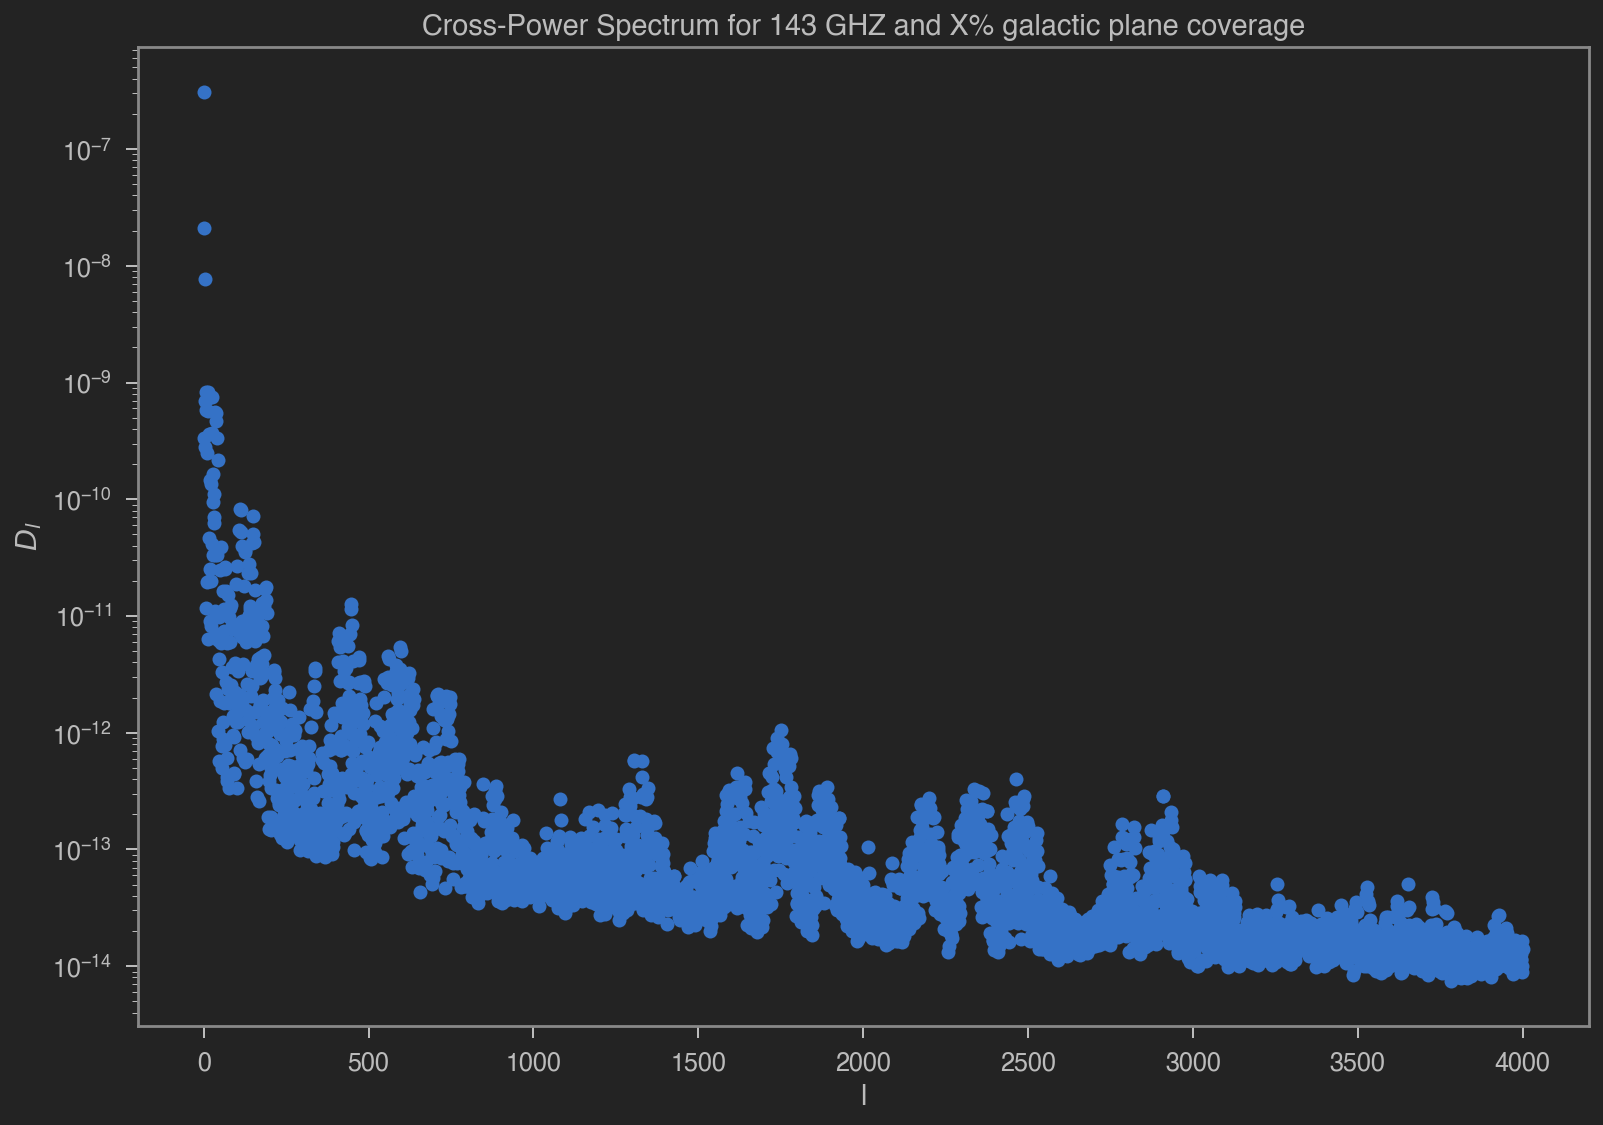

In [48]:
l = np.arange(len(D_l))
#C_l_binned = l*(l+1)+C_l/(2*np.pi)
galperc = 'X'

fig, ax = plt.subplots(figsize=(13,9))

ax.plot(l, D_l, 'o')
#ax.set_xlim([100,4000])
ax.set_yscale('log')

ax.set_xlabel('l')
#ax.set_ylabel(r'$\frac{l(l-1)}{2\pi} C_l$')
ax.set_ylabel(r'$D_l$')
ax.set_title(f'Cross-Power Spectrum for 143 GHZ and {galperc}% galactic plane coverage')

plt.show()